# Model Evaluation

## Agenda

1. Null accuracy, handling missing values
2. Confusion matrix, sensitivity, specificity, setting a threshold
3. Handling categorical features, interpreting logistic regression coefficients
4. Cross-Validation

## Part 1: Null Accuracy, Handling Missing Values

Recall the Lab from last lesson on Logistic Regression. We will be revisting the ideas introduced using the Titanic dataset again.

For a description of the Titanic dataset see this Kaggle page: https://www.kaggle.com/c/titanic/data

In [66]:
# TASK 1: read the data from titanic.csv into a DataFrame
import pandas as pd
titanic = pd.read_csv('titanic.csv', index_col='PassengerId')

In [67]:
titanic.head()


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [68]:
# TASK 2: define Pclass/Parch as the features and Survived as the response
feature_cols = ['Pclass', 'Parch']
X = titanic[feature_cols]
y = titanic.Survived
#X = ___
#y = ___

In [72]:
# TASK 3: split the data into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [73]:
# TASK 4: fit a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [74]:
# TASK 5: make predictions on testing set and calculate accuracy
y_pred_class = logreg.predict(X_test)
from sklearn import metrics
print (metrics.accuracy_score(y_test, y_pred_class))

0.6681614349775785


### Null accuracy

Null accuracy is the accuracy that could be achieved by always predicting the **most frequent class**. It is a baseline against which you may want to measure your classifier.

In [75]:
y_test.describe()

count    223.000000
mean       0.426009
std        0.495607
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

In [76]:
# compute null accuracy manually
print (y_test.mean())
print (1 - y_test.mean())

0.4260089686098655
0.5739910313901345


In [78]:
# equivalent function in scikit-learn
# http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html
from sklearn.dummy import DummyClassifier
dumb = DummyClassifier(strategy='most_frequent')
dumb.fit(X_train, y_train)
y_dumb_class = dumb.predict(X_test)
print (metrics.accuracy_score(y_test, y_dumb_class))

0.5739910313901345


### Handling missing values

scikit-learn models expect that all values are **numeric** and **hold meaning**. Thus, missing values are not allowed by scikit-learn.

One possible strategy is to just **drop missing values**:

In [82]:
# check for missing values
titanic.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [14]:
# drop rows with any missing values
titanic.dropna().shape

(183, 11)

In [15]:
# drop rows where Age is missing
titanic[titanic.Age.notnull()].shape

(714, 11)

Sometimes a better strategy is to **impute missing values**:

In [16]:
# fill missing values for Age with the mean age
# titanic.Age = titanic.Age.fillna(titanic.Age.mean()

titanic.Age.fillna(titanic.Age.mean(), inplace=True)

In [83]:
# equivalent function in scikit-learn, supports mean/median/most_frequent
from sklearn.preprocessing import Imputer
imp = Imputer(strategy='mean', axis=1)
titanic['Age'] = imp.fit_transform(titanic.Age.values.reshape(1,-1)).T

In [84]:
# include Age as a feature
feature_cols = ['Pclass', 'Parch', 'Age']
X = titanic[feature_cols]

from sklearn.model_selection import train_test_split


# TASK : split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
# TASK : fit a logistic regression model
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)
# TASK : make predictions on testing set and calculate accuracy
y_pred_class = logreg.predict(X_test)

print (metrics.accuracy_score(y_test, y_pred_class))

0.672645739910314


## Part 2: Confusion Matrix

In [85]:
# confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[107,  21],
       [ 52,  43]])

For a plotting function that will plot a nice confusion matrix see: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [86]:
# %load confusion_matrix_nice.py
# from confusion_matrix_nice import plot_confusion_matrix
%run confusion_matrix_nice

In [87]:
! ls

bikeshare.csv		  confusion_matrix_nice.pyc	    titanic.csv
bikeshare.txt		  Lab 6 A - bias_variance.ipynb
confusion_matrix_nice.py  Lab 6 B - model_evaluation.ipynb


Confusion matrix, without normalization
[[107  21]
 [ 52  43]]


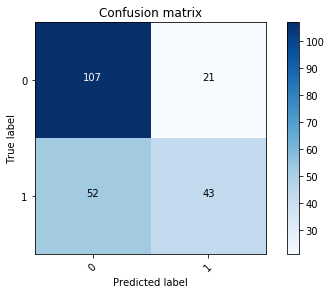

In [24]:
# plot an attractive confusion matrix
cnf_mat = metrics.confusion_matrix(y_test, y_pred_class, labels = titanic.Survived.unique())
class_labels = titanic.Survived.unique()
plt.figure()
plot_confusion_matrix(cnf_mat, class_labels,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
plt.show()

In [88]:
# calculate the sensitivity
43 / float(52 + 43)

0.45263157894736844

In [89]:
# calculate the specificity
107 / float(107 + 21)

0.8359375

In [91]:
# store the predicted probabilities
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

Text(0,0.5,'Frequency')

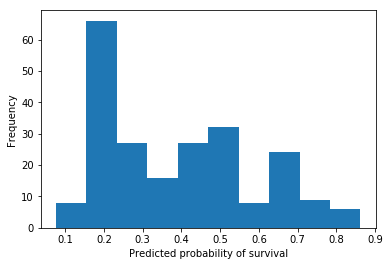

In [92]:
# plot the predicted probabilities
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(y_pred_prob)
plt.xlabel('Predicted probability of survival')
plt.ylabel('Frequency')

In [93]:
# change the threshold for predicting survived to increase sensitivity
import numpy as np
y_pred_class = np.where(y_pred_prob > 0.25, 1, 0)

In [94]:
# equivalent function in scikit-learn
from sklearn.preprocessing import binarize
y_pred_class = binarize(y_pred_prob.reshape(1,-1), 0.25).T

In [95]:
# new confusion matrix
print (metrics.confusion_matrix(y_test, y_pred_class))

[[57 71]
 [27 68]]


In [96]:
# new sensitivity
print (68 / float(27 + 68))

0.7157894736842105


In [97]:
# new specificity
print (57 / float(57 + 71))

0.4453125


## Part 3: Cross Validation Example on Bike Share

#### Intro to cross validation with bike share data

In [98]:
from sklearn import cross_validation
bikeshare = pd.read_csv('bikeshare.csv')

In [99]:
bikeshare.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [100]:
bikeshare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


#### Create dummy variables and set outcome (dependent) variable

In [43]:
weather = pd.get_dummies(bikeshare.weathersit, prefix='weather')
modeldata = bikeshare[['temp', 'hum']].join(weather[['weather_1', 'weather_2', 'weather_3']])
y = bikeshare.casual 

#### Create a cross validation with 5 folds

In [44]:
kf = cross_validation.KFold(len(modeldata), n_folds=5, shuffle=True)

In [48]:
from sklearn import linear_model

In [49]:
mse_values = []
scores = []
n= 0
print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf:
    lm = linear_model.LinearRegression().fit(modeldata.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(modeldata.iloc[test_index])))
    scores.append(lm.score(modeldata, y))
    n+=1
    print ('Model', n)
    print ('MSE:', mse_values[n-1])
    print ('R2:', scores[n-1])


print ("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print ('Mean of MSE for all folds:', np.mean(mse_values))
print ('Mean of R2 for all folds:', np.mean(scores))

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 1720.6538274652432
R2: 0.3119133948946582
Model 2
MSE: 1699.0431752671211
R2: 0.3119051587864532
Model 3
MSE: 1664.380823845971
R2: 0.31190859878359445
Model 4
MSE: 1663.7720765364281
R2: 0.3119113871942628
Model 5
MSE: 1618.2469916483733
R2: 0.3118876959143927
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 1673.2193789526275
Mean of R2 for all folds: 0.31190524711467227


In [53]:
lm = linear_model.LinearRegression().fit(modeldata, y)
print ("~~~~ Single Model ~~~~")
print ('MSE of single model:', metrics.mean_squared_error(y, lm.predict(modeldata)))
print ('R2: ', lm.score(modeldata, y))

~~~~ Single Model ~~~~
MSE of single model: 1672.5811076539346
R2:  0.31193460598906453


### Check
While the cross validated approach here generated more overall error, which of the two approaches would predict new data more accurately: the single model or the cross validated, averaged one? Why?


Answer: 

## Part 4: Apply Cross Validation to the Titanic Dataset

In [54]:
import pandas as pd
titanic = pd.read_csv('titanic.csv', index_col='PassengerId')

In [56]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

In [62]:
feature_cols = ['Pclass', 'Parch', 'Age']
X = titanic[feature_cols]
X.Age.fillna(X.Age.mean(), inplace=True)
X.Age

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


PassengerId
1      22.000000
2      38.000000
3      26.000000
4      35.000000
5      35.000000
6      29.699118
7      54.000000
8       2.000000
9      27.000000
10     14.000000
11      4.000000
12     58.000000
13     20.000000
14     39.000000
15     14.000000
16     55.000000
17      2.000000
18     29.699118
19     31.000000
20     29.699118
21     35.000000
22     34.000000
23     15.000000
24     28.000000
25      8.000000
26     38.000000
27     29.699118
28     19.000000
29     29.699118
30     29.699118
         ...    
862    21.000000
863    48.000000
864    29.699118
865    24.000000
866    42.000000
867    27.000000
868    31.000000
869    29.699118
870     4.000000
871    26.000000
872    47.000000
873    33.000000
874    47.000000
875    28.000000
876    15.000000
877    20.000000
878    19.000000
879    29.699118
880    56.000000
881    25.000000
882    33.000000
883    22.000000
884    28.000000
885    25.000000
886    39.000000
887    27.000000
888    19.000000
88

In [63]:

y = titanic.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
logreg=LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)
zip(feature_cols, logreg.coef_[0])

In [64]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=100)
print (scores)
print (scores.mean())

[0.8        0.7        0.3        0.7        0.7        0.6
 0.8        0.5        0.6        0.9        0.5        0.5
 0.6        0.6        0.6        0.5        0.7        0.6
 0.7        0.8        0.7        0.8        0.8        0.7
 0.5        0.5        0.9        0.7        0.8        0.6
 0.8        0.5        0.9        0.6        0.4        0.6
 0.9        0.8        0.6        0.7        0.7        0.8
 0.88888889 0.66666667 0.77777778 0.77777778 0.66666667 0.77777778
 0.55555556 0.875      0.75       0.625      0.625      0.75
 0.625      0.75       0.75       0.75       0.75       0.75
 0.625      0.75       0.875      0.625      0.875      1.
 0.875      0.75       0.875      0.75       0.5        0.75
 0.75       0.625      0.875      0.625      0.75       0.875
 0.875      0.875      0.625      0.875      0.625      0.625
 0.875      0.75       0.625      0.5        0.75       0.625
 0.75       0.625      0.75       0.75       1.         0.875
 0.625      0.625      

### Task: Evaluate each stage of the model with Cross-Validation

### Task: Evaluate the Cross-Validation score with different values of n (2, 5, 10, 50)

### Task: Experiment with differen model evaluation metrics form sci-kit learn

See a list of model evaluatin metrics here. Particulary try precision and recall and f1. Read about available methods and what they mean here:
http://scikit-learn.org/stable/modules/model_evaluation.html

